In [1]:
import requests
import pandas as pd

def get_average_dataframe(indicator, product_code, processing_code):
    url = "https://api.wto.org/timeseries/v1/data"
    headers = {
        "Ocp-Apim-Subscription-Key": "9ec85e37573c4ad7ab5c92e461239b3b"
    }

    params = {
        "i": indicator,
        "r": "032,068,076,152,170,188,214,218,222,320,340,484,558,591,600,604,858,862",
        "pc": processing_code,
        "ps": "1980-2024",
        "fmt": "json",
        "max": 1000
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        data = response.json()

        # Extract relevant data from the 'Dataset' key
        dataset = data.get('Dataset', [])
        if dataset:
            # Create a DataFrame
            df = pd.DataFrame(dataset)

            # Select only 'Year', 'ReportingEconomy', and 'Value' columns
            df_final = df[['Year', 'ReportingEconomy', 'Value']]

            # Pivot the DataFrame to long format
            df_long = df_final.pivot(index='ReportingEconomy', columns='Year', values='Value')

            # Reset the index to make 'ReportingEconomy' a regular column
            df_long.reset_index(inplace=True)

            # Calculate average across all years for each country
            df_average = df_long.copy()
            df_average['AverageValue'] = df_average.iloc[:, 1:].mean(axis=1)

            # Select only 'ReportingEconomy' and 'AverageValue' columns
            df_average = df_average[['ReportingEconomy', 'AverageValue']]

            # Rename columns systematically
            df_average.columns = ['Country', f'AverageValue_{product_code}']

            # Print or further process the DataFrame
            print(df_average)
            return df_average
        else:
            print("No data in the 'Dataset' key.")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

# Example usage:
df_av_to = get_average_dataframe("ITS_MTV_AX", "TO", "TO")
df_av_mamt = get_average_dataframe("ITS_MTV_AX", "MAMT", "MAMT")
df_av_sox = get_average_dataframe("ITS_CS_AX6", "SOX", "SOX")

# Merge DataFrames
merged_df = pd.merge(df_av_to, df_av_mamt, on='Country', how='outer', suffixes=('_to', '_mamt'))
merged_df = pd.merge(merged_df, df_av_sox, on='Country', how='outer', suffixes=('_mamt', '_sox'))

# Rename columns systematically
column_rename_dict = {f'AverageValue_{product_code}': f'{code}_{product_code}' for code, product_code in [('A', 'TO'), ('B', 'MAMT'), ('C', 'SOX')]}
merged_df.rename(columns=column_rename_dict, inplace=True)

# Calculate 'COM_DEP'
merged_df['COM_DEP'] = (merged_df['A_TO'] - merged_df['B_MAMT']) / (merged_df['A_TO'] + merged_df['C_SOX'])

# Print or further process the merged DataFrame
print(merged_df)


                              Country  AverageValue_TO
0                           Argentina     36661.581395
1     Bolivia, Plurinational State of      3967.674419
2                              Brazil    111513.790698
3                               Chile     36341.325581
4                            Colombia     21589.348837
5                          Costa Rica      6272.255814
6                  Dominican Republic      5635.674419
7                             Ecuador     10528.418605
8                         El Salvador      3017.348837
9                           Guatemala      5260.558140
10                           Honduras      4232.255814
11                             Mexico    197710.302326
12                          Nicaragua      2079.488372
13                             Panama      5154.395349
14                           Paraguay      3887.186047
15                               Peru     19272.162791
16                            Uruguay      4042.348837
17  Venezu

In [2]:
# Mapping dictionary for country codes
country_code_mapping = {
    'Argentina': 'ARG',
    'Bolivia, Plurinational State of': 'BOL',
    'Brazil': 'BRA',
    'Chile': 'CHL',
    'Colombia': 'COL',
    'Costa Rica': 'CRI',
    'Dominican Republic': 'DOM',
    'Ecuador': 'ECU',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Honduras': 'HND',
    'Mexico': 'MEX',
    'Nicaragua': 'NIC',
    'Panama': 'PAN',
    'Paraguay': 'PRY',
    'Peru': 'PER',
    'Uruguay': 'URY',
    'Venezuela, Bolivarian Republic of': 'VEN'
}

# Add a new column 'Country Code' based on the mapping
merged_df['Country Code'] = merged_df['Country'].map(country_code_mapping)

# Display the updated DataFrame
print("Updated Merged DataFrame:")
print(merged_df)


Updated Merged DataFrame:
                              Country           A_TO         B_MAMT  \
0                           Argentina   36661.581395    5368.382353   
1     Bolivia, Plurinational State of    3967.674419      66.794118   
2                              Brazil  111513.790698   22821.606061   
3                               Chile   36341.325581    1271.060606   
4                            Colombia   21589.348837    1046.848485   
5                          Costa Rica    6272.255814    1471.606061   
6                  Dominican Republic    5635.674419     698.645161   
7                             Ecuador   10528.418605     242.848485   
8                         El Salvador    3017.348837     184.939394   
9                           Guatemala    5260.558140     160.151515   
10                           Honduras    4232.255814     219.060606   
11                             Mexico  197710.302326  138827.294118   
12                          Nicaragua    2079.48837

In [4]:
import requests
import pandas as pd

# Set API endpoint and parameters
url = 'http://api.worldbank.org/v2/country'
params = {
    'format': 'json',
    'date': '1960:2023'
}

# Revised Latin American (NLSCE) countries
nlsce_countries = ['PRY', 'PAN', 'DOM', 'GTM', 'CRI', 'HND', 'SLV', 'MEX']

# Revised top remittance-receiving countries for LSCE
lsce_top_remittance_countries = ['BOL', 'VEN', 'NIC', 'CHL', 'PER', 'ECU', 'COL', 'ARG', 'URY', 'BRA']

# Indicators of interest
indicators = [
    'DT.TDS.DECT.CD',      # Debt service on external debt
    'NE.EXP.GNFS.CD'       # Total merchandise exports
]

# Create DataFrames to hold data for NLSCE and LSCE top remittance countries
df_nlsce = pd.DataFrame(columns=['Country', 'Indicator', 'Year', 'Value'])
df_lsce_top_remittance = pd.DataFrame(columns=['Country', 'Indicator', 'Year', 'Value'])

# Fetch data for each indicator in NLSCE countries
for country in nlsce_countries:
    for indicator in indicators:
        country_url = f"{url}/{country}/indicator/{indicator}"
        response = requests.get(country_url, params=params)
        
        # Check if the response contains data
        if response.ok:
            data = response.json()
            
            # Check if the data list is not empty and has the expected structure
            if isinstance(data, list) and len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    year = item.get('date', '')
                    value = item.get('value', '')

                    # Append the data to the NLSCE DataFrame
                    df_nlsce = pd.concat([df_nlsce, pd.DataFrame({
                        'Country': [country],
                        'Indicator': [indicator],
                        'Year': [year],
                        'Value': [value]
                    })], ignore_index=True)

# Fetch data for each indicator in LSCE top remittance countries
for country in lsce_top_remittance_countries:
    for indicator in indicators:
        country_url = f"{url}/{country}/indicator/{indicator}"
        response = requests.get(country_url, params=params)
        
        # Check if the response contains data
        if response.ok:
            data = response.json()
            
            # Check if the data list is not empty and has the expected structure
            if isinstance(data, list) and len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    year = item.get('date', '')
                    value = item.get('value', '')

                    # Append the data to the LSCE top remittance DataFrame
                    df_lsce_top_remittance = pd.concat([df_lsce_top_remittance, pd.DataFrame({
                        'Country': [country],
                        'Indicator': [indicator],
                        'Year': [year],
                        'Value': [value]
                    })], ignore_index=True)

# Pivot the DataFrames to long format
df_nlsce_pivot = df_nlsce.pivot_table(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()
df_lsce_top_remittance_pivot = df_lsce_top_remittance.pivot_table(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()

# Calculate average value per country
df_nlsce_avg = df_nlsce_pivot.groupby('Country').mean(numeric_only=True).reset_index()
df_lsce_top_remittance_avg = df_lsce_top_remittance_pivot.groupby('Country').mean(numeric_only=True).reset_index()

# Keep only 'Country' and 'Average Value'
df_nlsce_avg = df_nlsce_avg[['Country', 'DT.TDS.DECT.CD', 'NE.EXP.GNFS.CD']]
df_lsce_top_remittance_avg = df_lsce_top_remittance_avg[['Country', 'DT.TDS.DECT.CD', 'NE.EXP.GNFS.CD']]

# Rename columns
df_nlsce_avg.columns = ['Country', 'Average Debt Service', 'Average Merchandise Exports']
df_lsce_top_remittance_avg.columns = ['Country', 'Average Debt Service', 'Average Merchandise Exports']

# Calculate Debt Service as a share of Merchandise Exports
df_nlsce_avg['Debt Service Share'] = df_nlsce_avg['Average Debt Service'] / df_nlsce_avg['Average Merchandise Exports']
df_lsce_top_remittance_avg['Debt Service Share'] = df_lsce_top_remittance_avg['Average Debt Service'] / df_lsce_top_remittance_avg['Average Merchandise Exports']

# Display the DataFrames with the average values and Debt Service Share
print("NLSCE Average Values per Country:")
print(df_nlsce_avg)

print("\nLSCE Top Remittance Average Values per Country:")
print(df_lsce_top_remittance_avg)


NLSCE Average Values per Country:
  Country  Average Debt Service  Average Merchandise Exports  \
0     CRI          1.104652e+09                 7.780780e+09   
1     DOM          1.237893e+09                 8.074865e+09   
2     GTM          9.940830e+08                 5.700619e+09   
3     HND          5.050160e+08                 4.396492e+09   
4     MEX          3.229883e+10                 1.859735e+11   
5     PAN          1.872416e+09                 9.577065e+09   
6     PRY          6.347002e+08                 5.815441e+09   
7     SLV          1.003736e+09                 3.214430e+09   

   Debt Service Share  
0            0.141972  
1            0.153302  
2            0.174382  
3            0.114868  
4            0.173674  
5            0.195510  
6            0.109141  
7            0.312259  

LSCE Top Remittance Average Values per Country:
  Country  Average Debt Service  Average Merchandise Exports  \
0     ARG          1.315119e+10                 4.510522e+10

In [6]:
# Merge the two DataFrames
latam_debt = pd.concat([df_nlsce_avg, df_lsce_top_remittance_avg], ignore_index=True)

# Add a 'Group' column
latam_debt['Group'] = latam_debt['Country'].apply(lambda x: 'NLSCE' if x in nlsce_countries else 'LSCE')

# Display the merged DataFrame
print("Merged Latam Debt DataFrame:")
print(latam_debt)


Merged Latam Debt DataFrame:
   Country  Average Debt Service  Average Merchandise Exports  \
0      CRI          1.104652e+09                 7.780780e+09   
1      DOM          1.237893e+09                 8.074865e+09   
2      GTM          9.940830e+08                 5.700619e+09   
3      HND          5.050160e+08                 4.396492e+09   
4      MEX          3.229883e+10                 1.859735e+11   
5      PAN          1.872416e+09                 9.577065e+09   
6      PRY          6.347002e+08                 5.815441e+09   
7      SLV          1.003736e+09                 3.214430e+09   
8      ARG          1.315119e+10                 4.510522e+10   
9      BOL          5.629944e+08                 4.169625e+09   
10     BRA          4.519325e+10                 1.602740e+11   
11     CHL                   NaN                 3.655969e+10   
12     COL          7.642551e+09                 2.321108e+10   
13     ECU          2.740456e+09                 1.040329e+10

In [7]:
# Merge latam_debt and merged_df on 'Country Code' and 'Country' columns
com_debt_latam = pd.merge(latam_debt, merged_df, left_on='Country', right_on='Country Code', how='inner')

# Display the merged DataFrame
print("Merged Debt Latam DataFrame:")
print(com_debt_latam)


Merged Debt Latam DataFrame:
   Country_x  Average Debt Service  Average Merchandise Exports  \
0        CRI          1.104652e+09                 7.780780e+09   
1        DOM          1.237893e+09                 8.074865e+09   
2        GTM          9.940830e+08                 5.700619e+09   
3        HND          5.050160e+08                 4.396492e+09   
4        MEX          3.229883e+10                 1.859735e+11   
5        PAN          1.872416e+09                 9.577065e+09   
6        PRY          6.347002e+08                 5.815441e+09   
7        SLV          1.003736e+09                 3.214430e+09   
8        ARG          1.315119e+10                 4.510522e+10   
9        BOL          5.629944e+08                 4.169625e+09   
10       BRA          4.519325e+10                 1.602740e+11   
11       CHL                   NaN                 3.655969e+10   
12       COL          7.642551e+09                 2.321108e+10   
13       ECU          2.740456e+0

In [8]:
# Merge latam_debt and merged_df on 'Country Code' and 'Country' columns
com_debt_latam = pd.merge(latam_debt, merged_df, left_on='Country', right_on='Country Code', how='inner')

# Calculate the average Debt Service Share for CHL and URY
avg_debt_service_chl = com_debt_latam.loc[com_debt_latam['Country_x'].isin(['BOL', 'PER']), 'Debt Service Share'].mean()
avg_debt_service_ury = com_debt_latam.loc[com_debt_latam['Country_x'].isin(['BRA', 'ARG']), 'Debt Service Share'].mean()

# Update Debt Service Share for CHL and URY in the merged DataFrame
com_debt_latam.loc[com_debt_latam['Country_x'] == 'CHL', 'Debt Service Share'] = avg_debt_service_chl
com_debt_latam.loc[com_debt_latam['Country_x'] == 'URY', 'Debt Service Share'] = avg_debt_service_ury

# Display the updated merged DataFrame
print("Updated Debt Latam DataFrame:")
print(com_debt_latam)


Updated Debt Latam DataFrame:
   Country_x  Average Debt Service  Average Merchandise Exports  \
0        CRI          1.104652e+09                 7.780780e+09   
1        DOM          1.237893e+09                 8.074865e+09   
2        GTM          9.940830e+08                 5.700619e+09   
3        HND          5.050160e+08                 4.396492e+09   
4        MEX          3.229883e+10                 1.859735e+11   
5        PAN          1.872416e+09                 9.577065e+09   
6        PRY          6.347002e+08                 5.815441e+09   
7        SLV          1.003736e+09                 3.214430e+09   
8        ARG          1.315119e+10                 4.510522e+10   
9        BOL          5.629944e+08                 4.169625e+09   
10       BRA          4.519325e+10                 1.602740e+11   
11       CHL                   NaN                 3.655969e+10   
12       COL          7.642551e+09                 2.321108e+10   
13       ECU          2.740456e+

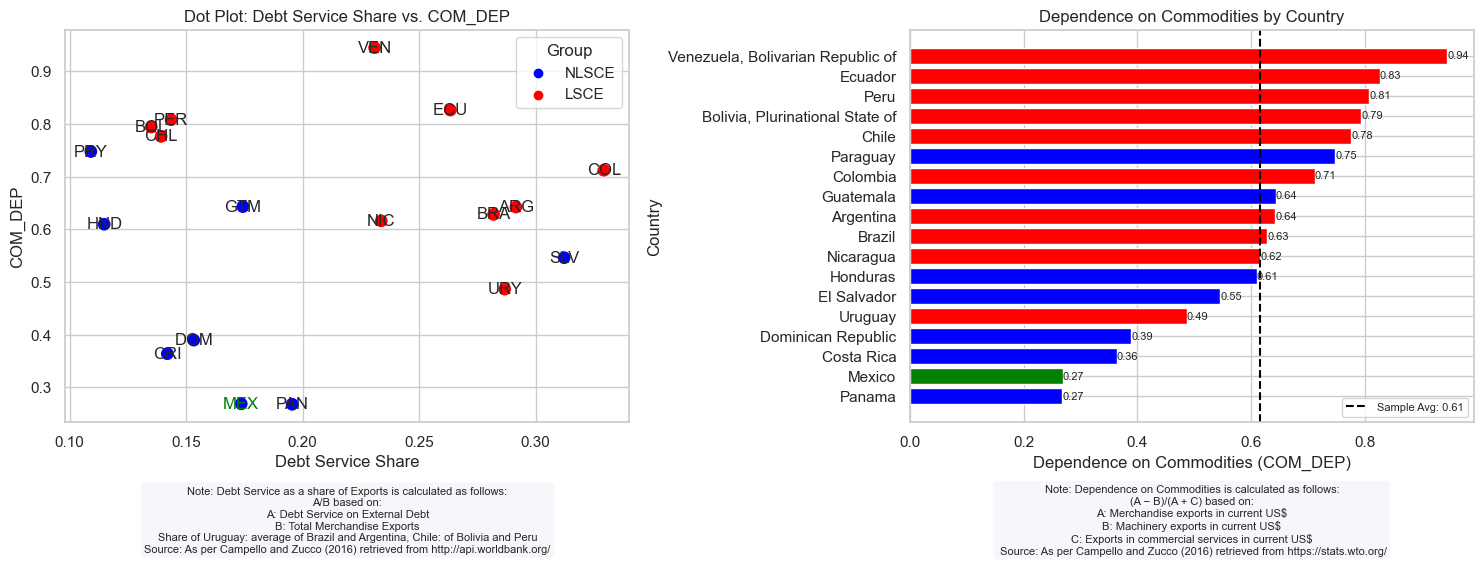

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Create a 1-row, 2-column subplot layout
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for Debt Service Share vs. COM_DEP
scatter_plot = sns.scatterplot(data=com_debt_latam, x='Debt Service Share', y='COM_DEP', hue='Group', palette={'LSCE': 'red', 'NLSCE': 'blue'}, s=100, ax=axes[0])

# Annotate points with country codes
for i, row in com_debt_latam.iterrows():
    color = 'green' if row['Country_y'] == 'Mexico' else None
    axes[0].text(row['Debt Service Share'], row['COM_DEP'], row['Country Code'], ha='center', va='center', color=color)

# Set labels and title for the first plot
axes[0].set_xlabel('Debt Service Share')
axes[0].set_ylabel('COM_DEP')
axes[0].set_title('Dot Plot: Debt Service Share vs. COM_DEP')
axes[0].legend(title='Group')

# Add note to the left plot
note_left = "Note: Debt Service as a share of Exports is calculated as follows:\nA/B based on:\nA: Debt Service on External Debt\nB: Total Merchandise Exports\nShare of Uruguay: average of Brazil and Argentina, Chile: of Bolivia and Peru\nSource: As per Campello and Zucco (2016) retrieved from http://api.worldbank.org/"
axes[0].annotate(note_left, xy=(0.5, -0.25), xycoords="axes fraction", ha="center", va="center", fontsize=8, bbox=dict(boxstyle="round", alpha=0.05))

# Bar plot for Dependence on Commodities (COM_DEP)
merged_df_sorted = com_debt_latam.sort_values(by='COM_DEP')
colors_right = ['green' if country == 'Mexico' else 'red' if group == 'LSCE' else 'blue' for country, group in zip(merged_df_sorted['Country_y'], merged_df_sorted['Group'])]
bars = axes[1].barh(merged_df_sorted['Country_y'], merged_df_sorted['COM_DEP'], color=colors_right)
axes[1].set_xlabel('Dependence on Commodities (COM_DEP)')
axes[1].set_ylabel('Country')
axes[1].set_title('Dependence on Commodities by Country')

# Add data labels to the bars
for bar in bars:
    axes[1].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left', fontsize=8)

# Add a note for the second plot
note_right = "Note: Dependence on Commodities is calculated as follows:\n(A − B)/(A + C) based on:\nA: Merchandise exports in current US$\nB: Machinery exports in current US$\nC: Exports in commercial services in current US$\n Source: As per Campello and Zucco (2016) retrieved from https://stats.wto.org/"
axes[1].annotate(note_right, xy=(0.5, -0.25), xycoords="axes fraction", ha="center", va="center", fontsize=8, bbox=dict(boxstyle="round", alpha=0.05))

# Add a horizontal line for the average of the sample in the right plot
axes[1].axvline(x=com_debt_latam['COM_DEP'].mean(), color='black', linestyle='--', label=f'Sample Avg: {com_debt_latam["COM_DEP"].mean():.2f}')

# Place legend in the bottom right corner for the right plot
axes[1].legend(loc='lower right', fontsize=8)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig(r'C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q4.23_FQExamination\1.CPE\0. Presidential Success Mexico\com_debt_latam.png')

# Show the plots
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


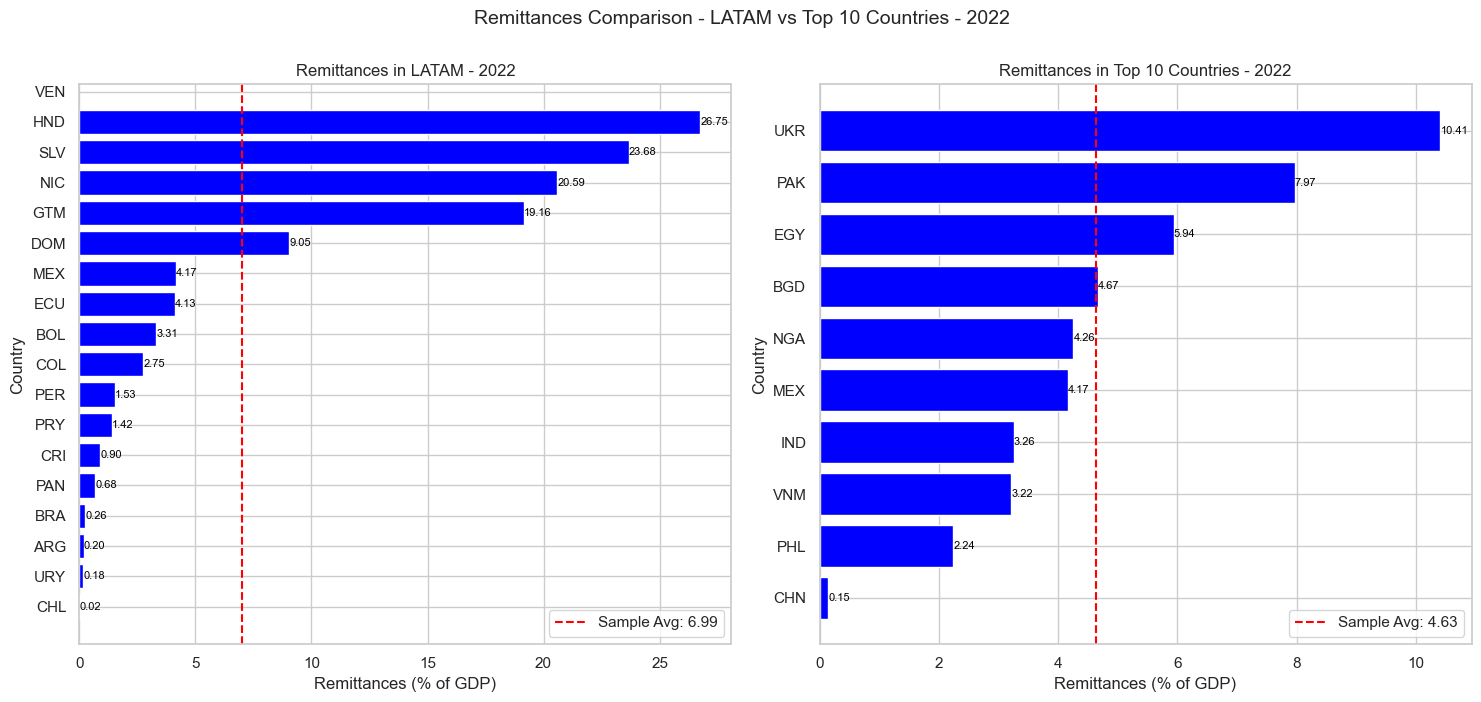

In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Set API endpoint and parameters
url = 'http://api.worldbank.org/v2/country'
params = {
    'format': 'json',
    'date': '1960:2023'
}

# Updated Latin American (LATAM) countries
latam_countries = ['ARG', 'BRA', 'MEX', 'COL', 'VEN', 'PER', 'CHL', 'ECU', 'CRI', 'URY', 'BOL', 'PRY', 'GTM', 'HND', 'NIC', 'PAN', 'DOM', 'SLV']

# Top 10 remittance-receiving countries
top_remittance_countries = ['IND', 'CHN', 'PHL', 'MEX', 'EGY', 'BGD', 'VNM', 'PAK', 'NGA', 'UKR']

# Indicator of interest
indicator = 'BX.TRF.PWKR.DT.GD.ZS'   # Personal remittances, received (% of GDP)

# Create DataFrame to hold data for LATAM countries
df_latam = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in LATAM countries
for country in latam_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    
    # Check if the response contains data
    if len(response.json()) > 1:
        data = response.json()[1]

        if data:
            for item in data:
                year = item.get('date', '')
                value = item.get('value', '')

                # Append the data to the LATAM DataFrame
                df_latam = pd.concat([df_latam, pd.DataFrame({
                    'Country': [country],
                    'Year': [year],
                    'Value': [value]
                })], ignore_index=True)

# Extract the latest (2022) values for LATAM countries
latest_values_latam = df_latam[df_latam['Year'] == '2022']

# Sort values in descending order
ranked_df_2022_latam = latest_values_latam.sort_values(by='Value', ascending=True)

# Calculate sample average for 2022 in LATAM
sample_avg_2022_latam = ranked_df_2022_latam['Value'].mean()

# Create DataFrame to hold data for top remittance countries
df_top_remittance = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in the top remittance countries
for country in top_remittance_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    data = response.json()[1]

    if data:
        for item in data:
            year = item.get('date', '')
            value = item.get('value', '')

            # Append the data to the top remittance DataFrame
            df_top_remittance = pd.concat([df_top_remittance, pd.DataFrame({
                'Country': [country],
                'Year': [year],
                'Value': [value]
            })], ignore_index=True)

# Extract the latest (2022) values for top remittance countries
latest_values_top = df_top_remittance[df_top_remittance['Year'] == '2022']

# Sort values in descending order
ranked_df_2022_top = latest_values_top.sort_values(by='Value', ascending=True)

# Calculate sample average for 2022 in top remittance countries
sample_avg_2022_top = ranked_df_2022_top['Value'].mean()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot for LATAM on the left
bars_latam = axs[0].barh(ranked_df_2022_latam['Country'], ranked_df_2022_latam['Value'], color='blue')
axs[0].axvline(sample_avg_2022_latam, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_2022_latam:.2f}')
axs[0].set_title('Remittances in LATAM - 2022')
axs[0].set_xlabel('Remittances (% of GDP)')
axs[0].set_ylabel('Country')
axs[0].legend()

# Add data labels to each bar in LATAM plot
for bar_latam in bars_latam:
    axs[0].text(bar_latam.get_width(), bar_latam.get_y() + bar_latam.get_height()/2, f'{bar_latam.get_width():.2f}', 
                va='center', ha='left', color='black', fontsize=8)

# Plot for Top Remittance on the top right
bars_top = axs[1].barh(ranked_df_2022_top['Country'], ranked_df_2022_top['Value'], color='blue')
axs[1].axvline(sample_avg_2022_top, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_2022_top:.2f}')
axs[1].set_title('Remittances in Top 10 Countries - 2022')
axs[1].set_xlabel('Remittances (% of GDP)')
axs[1].set_ylabel('Country')
axs[1].legend()

# Add data labels to each bar in Top Remittance plot
for bar_top in bars_top:
    axs[1].text(bar_top.get_width(), bar_top.get_y() + bar_top.get_height()/2, f'{bar_top.get_width():.2f}', 
                va='center', ha='left', color='black', fontsize=8)

# Add title
plt.suptitle('Remittances Comparison - LATAM vs Top 10 Countries - 2022', y=1, fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(r'C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q4.23_FQExamination\1.CPE\0. Presidential Success Mexico\rem_lat_top.png')

# Show the plot
plt.show()


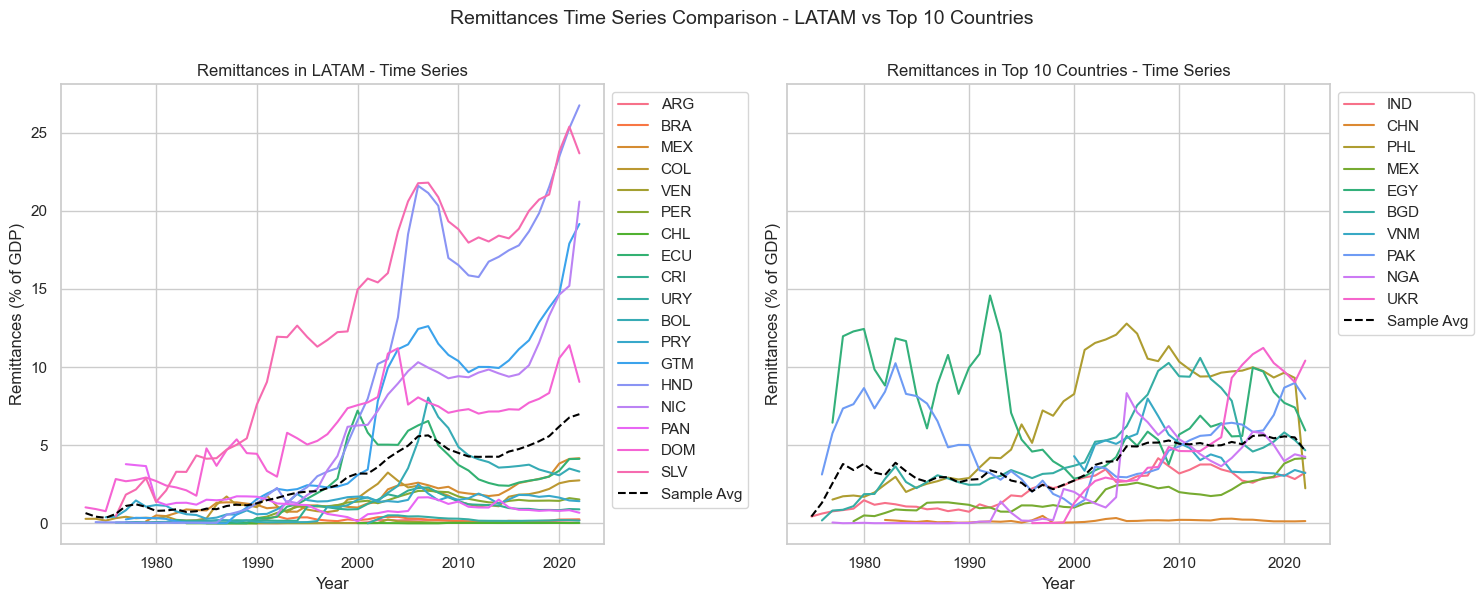

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for more vibrant colors

# Set Seaborn style
sns.set(style="whitegrid")

# Set API endpoint and parameters
url = 'http://api.worldbank.org/v2/country'
params = {
    'format': 'json',
    'date': '1960:2023'
}

# Updated Latin American (LATAM) countries
latam_countries = ['ARG', 'BRA', 'MEX', 'COL', 'VEN', 'PER', 'CHL', 'ECU', 'CRI', 'URY', 'BOL', 'PRY', 'GTM', 'HND', 'NIC', 'PAN', 'DOM', 'SLV']

# Top 10 remittance-receiving countries
top_remittance_countries = ['IND', 'CHN', 'PHL', 'MEX', 'EGY', 'BGD', 'VNM', 'PAK', 'NGA', 'UKR']

# Indicator of interest
indicator = 'BX.TRF.PWKR.DT.GD.ZS'   # Personal remittances, received (% of GDP)

# Create DataFrame to hold data for LATAM countries
df_latam = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in LATAM countries
for country in latam_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    
    # Check if the response contains data
    if len(response.json()) > 1:
        data = response.json()[1]

        if data:
            for item in data:
                year = item.get('date', '')
                value = item.get('value', '')

                # Append the data to the LATAM DataFrame
                df_latam = pd.concat([df_latam, pd.DataFrame({
                    'Country': [country],
                    'Year': [pd.to_datetime(year)],
                    'Value': [value]
                })], ignore_index=True)

# Create DataFrame to hold data for top remittance countries
df_top_remittance = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in the top remittance countries
for country in top_remittance_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    data = response.json()[1]

    if data:
        for item in data:
            year = item.get('date', '')
            value = item.get('value', '')

            # Append the data to the top remittance DataFrame
            df_top_remittance = pd.concat([df_top_remittance, pd.DataFrame({
                'Country': [country],
                'Year': [pd.to_datetime(year)],
                'Value': [value]
            })], ignore_index=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for LATAM
for country, color in zip(latam_countries, sns.color_palette('husl', n_colors=len(latam_countries))):
    data_latam = df_latam[df_latam['Country'] == country]
    axs[0].plot(data_latam['Year'], data_latam['Value'], label=country, color=color)

# Calculate sample average for LATAM
sample_avg_latam = df_latam.groupby('Year')['Value'].mean()
axs[0].plot(sample_avg_latam.index, sample_avg_latam.values, color='black', linestyle='--', label='Sample Avg')

axs[0].set_title('Remittances in LATAM - Time Series')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Remittances (% of GDP)')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot for Top Remittance
for country, color in zip(top_remittance_countries, sns.color_palette('husl', n_colors=len(top_remittance_countries))):
    data_top = df_top_remittance[df_top_remittance['Country'] == country]
    axs[1].plot(data_top['Year'], data_top['Value'], label=country, color=color)

# Calculate sample average for Top Remittance
sample_avg_top = df_top_remittance.groupby('Year')['Value'].mean()
axs[1].plot(sample_avg_top.index, sample_avg_top.values, color='black', linestyle='--', label='Sample Avg')

axs[1].set_title('Remittances in Top 10 Countries - Time Series')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Remittances (% of GDP)')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add title
plt.suptitle('Remittances Time Series Comparison - LATAM vs Top 10 Countries', y=1, fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('remhist_lat_top.png')

# Show the plot
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


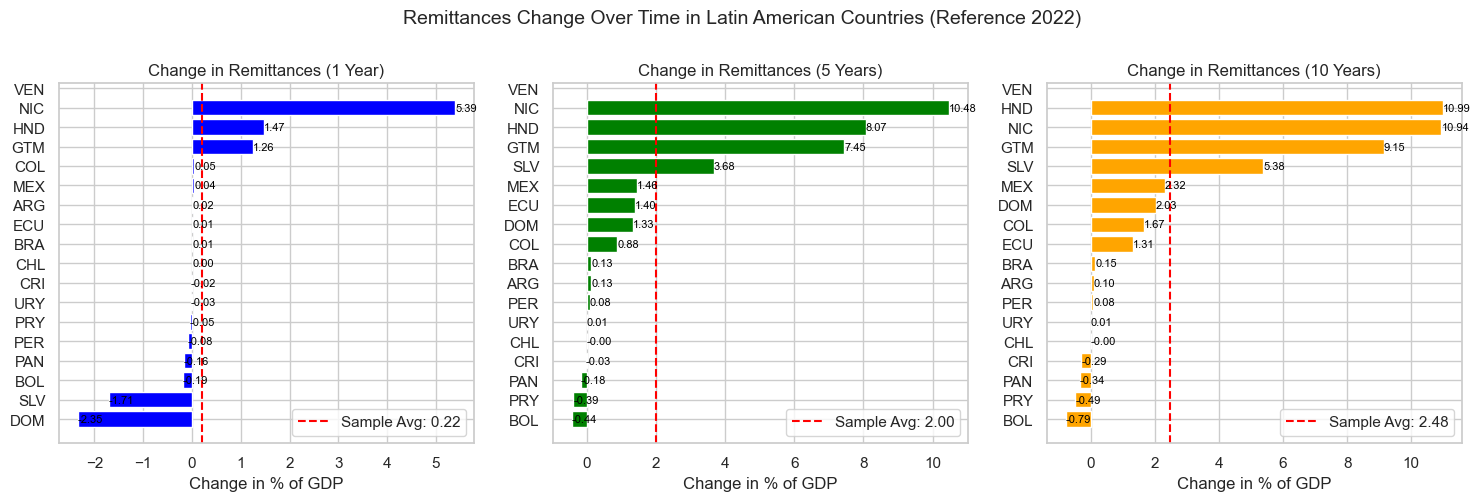

In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Set API endpoint and parameters
url = 'http://api.worldbank.org/v2/country'
params = {
    'format': 'json',
    'date': '1960:2023'
}

# Updated Latin American (LATAM) countries
latam_countries = ['ARG', 'BRA', 'MEX', 'COL', 'VEN', 'PER', 'CHL', 'ECU', 'CRI', 'URY', 'BOL', 'PRY', 'GTM', 'HND', 'NIC', 'PAN', 'DOM', 'SLV']

# Indicator of interest
indicator = 'BX.TRF.PWKR.DT.GD.ZS'   # Personal remittances, received (% of GDP)

# Create DataFrame to hold data for LATAM countries
df_latam = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in LATAM countries
for country in latam_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    
    # Check if the response contains data
    if len(response.json()) > 1:
        data = response.json()[1]

        if data:
            for item in data:
                year = item.get('date', '')
                value = item.get('value', '')

                # Append the data to the LATAM DataFrame
                df_latam = pd.concat([df_latam, pd.DataFrame({
                    'Country': [country],
                    'Year': [year],
                    'Value': [value]
                })], ignore_index=True)

# Extract the latest (2022), 1 year ago (2021), 5 years ago (2017), and 10 years ago (2012) values for each country
latest_values = df_latam[df_latam['Year'] == '2022']
one_year_ago_values = df_latam[df_latam['Year'] == '2021']
five_years_ago_values = df_latam[df_latam['Year'] == '2017']
ten_years_ago_values = df_latam[df_latam['Year'] == '2012']

# Merge the DataFrames on 'Country' to compare the values
merged_df = pd.merge(latest_values, one_year_ago_values, on='Country', suffixes=('_2022', '_2021'))
merged_df = pd.merge(merged_df, five_years_ago_values, on='Country', suffixes=('_2021', '_2017'))
merged_df = pd.merge(merged_df, ten_years_ago_values, on='Country', suffixes=('_2017', '_2012'))

# Calculate the changes for each time period
merged_df['Change_1_Year'] = merged_df['Value_2022'] - merged_df['Value_2021']
merged_df['Change_5_Years'] = merged_df['Value_2022'] - merged_df['Value_2017']
merged_df['Change_10_Years'] = merged_df['Value_2022'] - merged_df['Value_2012']

# Calculate sample average for each time period
sample_avg_1_year = merged_df['Change_1_Year'].mean()
sample_avg_5_years = merged_df['Change_5_Years'].mean()
sample_avg_10_years = merged_df['Change_10_Years'].mean()

# Rank values in ascending order for each time period
ranked_df_1_year = merged_df.sort_values(by='Change_1_Year', ascending=True)
ranked_df_5_years = merged_df.sort_values(by='Change_5_Years', ascending=True)
ranked_df_10_years = merged_df.sort_values(by='Change_10_Years', ascending=True)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 1 Year Plot
axs[0].barh(ranked_df_1_year['Country'], ranked_df_1_year['Change_1_Year'], color='blue')
axs[0].axvline(sample_avg_1_year, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_1_year:.2f}')
axs[0].set_title('Change in Remittances (1 Year)')
axs[0].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_1_year['Change_1_Year']):
    axs[0].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# 5 Years Plot
axs[1].barh(ranked_df_5_years['Country'], ranked_df_5_years['Change_5_Years'], color='green')
axs[1].axvline(sample_avg_5_years, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_5_years:.2f}')
axs[1].set_title('Change in Remittances (5 Years)')
axs[1].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_5_years['Change_5_Years']):
    axs[1].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# 10 Years Plot
axs[2].barh(ranked_df_10_years['Country'], ranked_df_10_years['Change_10_Years'], color='orange')
axs[2].axvline(sample_avg_10_years, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_10_years:.2f}')
axs[2].set_title('Change in Remittances (10 Years)')
axs[2].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_10_years['Change_10_Years']):
    axs[2].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# Add legend
for ax in axs:
    ax.legend()

# Add title
plt.suptitle('Remittances Change Over Time in Latin American Countries (Reference 2022)', y=1, fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(r'C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q4.23_FQExamination\1.CPE\0. Presidential Success Mexico\remlat_chg.png')

# Show the plot
plt.show()


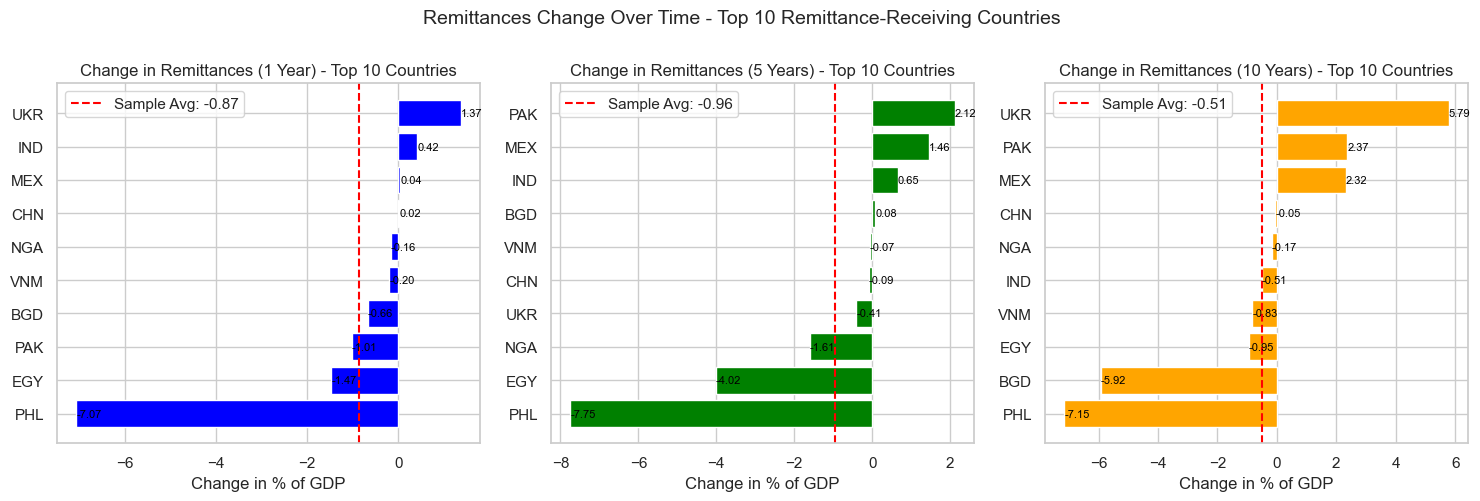

In [13]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Set API endpoint and parameters
url = 'http://api.worldbank.org/v2/country'
params = {
    'format': 'json',
    'date': '1960:2023'
}

# Top 10 remittance-receiving countries
top_remittance_countries = ['IND', 'CHN', 'PHL', 'MEX', 'EGY', 'BGD', 'VNM', 'PAK', 'NGA', 'UKR']

# Indicator of interest
indicator = 'BX.TRF.PWKR.DT.GD.ZS'   # Personal remittances, received (% of GDP)

# Create DataFrame to hold data for top remittance countries
df_top_remittance = pd.DataFrame(columns=['Country', 'Year', 'Value'])

# Fetch data for the indicator in the top remittance countries
for country in top_remittance_countries:
    country_url = f"{url}/{country}/indicator/{indicator}"
    response = requests.get(country_url, params=params)
    data = response.json()[1]

    if data:
        for item in data:
            year = item.get('date', '')
            value = item.get('value', '')

            # Append the data to the top remittance DataFrame
            df_top_remittance = pd.concat([df_top_remittance, pd.DataFrame({
                'Country': [country],
                'Year': [year],
                'Value': [value]
            })], ignore_index=True)

# Extract the latest (2022), 1 year ago (2021), 5 years ago (2017), and 10 years ago (2012) values for each country
latest_values_top = df_top_remittance[df_top_remittance['Year'] == '2022']
one_year_ago_values_top = df_top_remittance[df_top_remittance['Year'] == '2021']
five_years_ago_values_top = df_top_remittance[df_top_remittance['Year'] == '2017']
ten_years_ago_values_top = df_top_remittance[df_top_remittance['Year'] == '2012']

# Merge the DataFrames on 'Country' to compare the values
merged_df_top = pd.merge(latest_values_top, one_year_ago_values_top, on='Country', suffixes=('_2022', '_2021'))
merged_df_top = pd.merge(merged_df_top, five_years_ago_values_top, on='Country', suffixes=('_2021', '_2017'))
merged_df_top = pd.merge(merged_df_top, ten_years_ago_values_top, on='Country', suffixes=('_2017', '_2012'))

# Calculate the changes for each time period
merged_df_top['Change_1_Year'] = merged_df_top['Value_2022'] - merged_df_top['Value_2021']
merged_df_top['Change_5_Years'] = merged_df_top['Value_2022'] - merged_df_top['Value_2017']
merged_df_top['Change_10_Years'] = merged_df_top['Value_2022'] - merged_df_top['Value_2012']

# Calculate sample average for each time period
sample_avg_1_year_top = merged_df_top['Change_1_Year'].mean()
sample_avg_5_years_top = merged_df_top['Change_5_Years'].mean()
sample_avg_10_years_top = merged_df_top['Change_10_Years'].mean()

# Rank values in ascending order for each time period
ranked_df_1_year_top = merged_df_top.sort_values(by='Change_1_Year', ascending=True)
ranked_df_5_years_top = merged_df_top.sort_values(by='Change_5_Years', ascending=True)
ranked_df_10_years_top = merged_df_top.sort_values(by='Change_10_Years', ascending=True)

# Plotting for Top Remittance Countries
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 1 Year Plot
axs[0].barh(ranked_df_1_year_top['Country'], ranked_df_1_year_top['Change_1_Year'], color='blue')
axs[0].axvline(sample_avg_1_year_top, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_1_year_top:.2f}')
axs[0].set_title('Change in Remittances (1 Year) - Top 10 Countries')
axs[0].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_1_year_top['Change_1_Year']):
    axs[0].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# 5 Years Plot
axs[1].barh(ranked_df_5_years_top['Country'], ranked_df_5_years_top['Change_5_Years'], color='green')
axs[1].axvline(sample_avg_5_years_top, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_5_years_top:.2f}')
axs[1].set_title('Change in Remittances (5 Years) - Top 10 Countries')
axs[1].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_5_years_top['Change_5_Years']):
    axs[1].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# 10 Years Plot
axs[2].barh(ranked_df_10_years_top['Country'], ranked_df_10_years_top['Change_10_Years'], color='orange')
axs[2].axvline(sample_avg_10_years_top, color='red', linestyle='--', label=f'Sample Avg: {sample_avg_10_years_top:.2f}')
axs[2].set_title('Change in Remittances (10 Years) - Top 10 Countries')
axs[2].set_xlabel('Change in % of GDP')
for index, value in enumerate(ranked_df_10_years_top['Change_10_Years']):
    axs[2].text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=8)

# Add legend
for ax in axs:
    ax.legend()

# Add title
plt.suptitle('Remittances Change Over Time - Top 10 Remittance-Receiving Countries', y=1, fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(r'C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q4.23_FQExamination\1.CPE\0. Presidential Success Mexico\remtop_chg.png')

# Show the plot
plt.show()
